# Line Detection in Chest Radiographs

The goal of this notebook is to use pretrained ImageNet models and transfer learning to identify lines in . medical images. These lines can be catheters, tubes, or many other types of medical support devices. We are using the [Stanford CheXpert dataset](https://stanfordmlgroup.github.io/competitions/chexpert/) for training and validation. 

This is a binary classification problem. The network will simply determine if an X-ray image contains or does not contain any medical lines with the classes `Line` and `NoLine` respectively.

The end goal is to be able to use the weights in this network as a backbone for a more complex medical image segmentation network such as U-Net or Mask R-CNN.

## Python Imports

In [1]:
import cv2 
import keras
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sys
import tensorflow as tf
import time

from keras.applications.resnet50 import ResNet50
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from scipy.io import loadmat
from sklearn.preprocessing import normalize
from skimage.transform import rescale, resize
from tqdm import tqdm_notebook as tqdm

print(sys.version)
print(tf.__version__)
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
1.13.1


## Import Data

The names of the images with lines, and those without lines, are stored in a two separate text files. We will need to read these text files, load the images, then split them into training and testing sets.

In [2]:
# Set the input image size
input_size = (512, 512)

**Load the image list files**

Load the file containing paths to the line images, and the file containing paths to the noline images. (Loading images may take a few minutes)

In [7]:
#base_path = "/data/ryan_data/CheXpert/CheXpert-v1.0/train/" # Path to CheXpert dataset train/val folder 
base_path = "/data/mididata/rib_fracture_id/anon_chest2v_cropped/" # Path to CheXpert dataset train/val folder 
line_path = "./ped_line.txt"
noline_path = "./ped_noline.txt"

def load_image_cv(path):
    """Load grayscale image from path"""
    return cv2.imread(path)

def load_samples(file_path):
    images = []
    count = 0
    with open(file_path, mode="r", encoding="utf-8") as file:
        count = sum(1 for line in file)
    
    with open(file_path, mode="r", encoding="utf-8") as file:
        for image_path in tqdm(file, total=count, desc="Loading Images: "):
            path = os.path.join(base_path, image_path.rstrip())
            image = loadmat(path, appendmat=False)['dxImage']['img'][0][0]
            normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
            colored_image = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2RGB)
            images.append(cv2.resize(colored_image, input_size))
    return np.asarray(images)

line_images = load_samples(line_path)
noline_images = load_samples(noline_path)

Next we plot an image of each class to check that the dataset was loaded correctly

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 14))
ax[0].imshow(line_images[11], cmap="gray")
ax[0].set_title("Line")
ax[1].imshow(noline_images[11], cmap="gray")
ax[1].set_title("Noline")
plt.show()

print("Number of line images: {}".format(len(line_images)))
print("Number of noline images: {}".format(len(noline_images)))
print("Shape of each line sample: {}".format(line_images[0].shape))
print("Shape of each noline sample: {}".format(noline_images[0].shape))

**Combine Data and Labels**

Since our data is intially split into separate lists by class, we need to rearrange them into two ordered lists of sample images and their labels. We use the following binary labels:
* 0 = noline
* 1 = line

In [9]:
# If necessary, some methods may be included to improve the class split
total_samples = len(line_images) + len(noline_images)
line_percent = len(line_images) / total_samples * 100
noline_percent = len(noline_images) / total_samples * 100
print("Class split: {0: .2f}% line, {1: .2f}% noline".format(line_percent, noline_percent))

# Combine data into samples and labels arrays
samples = np.asarray([x for x in line_images] + [x for x in noline_images])
labels = np.asarray([(1,0) for x in line_images] + [(0,1) for x in noline_images])

samples = np.reshape(samples, (len(samples), input_size[0], input_size[1], 3))

# Print sample and label shapes
print("Samples shape: {}".format(samples.shape))
print("Labels shape: {}".format(labels.shape))

Class split:  27.86% line,  72.14% noline
Samples shape: (1102, 512, 512, 3)
Labels shape: (1102, 2)


**Create train/test/val sets**

Split the data into individual sets. Here we use a 70/15/15 split for training, validation, and testing respectively

In [21]:
# Randomize dataset ordering
ordering = np.arange(len(samples))
np.random.shuffle(ordering)
samples = samples[ordering]
labels = labels[ordering]


train_split = 0.7
val_split = 0.15
test_split = 0.15
n = len(samples)

# Split data
train_cutoff = int(n * train_split)
val_cutoff = int(train_cutoff + (n * val_split))
X_train, X_val, X_test = samples[:train_cutoff], samples[train_cutoff:val_cutoff], samples[val_cutoff:]
Y_train, Y_val, Y_test = labels[:train_cutoff], labels[train_cutoff:val_cutoff], labels[val_cutoff:]

print("Train length:\t{}\nVal Length:\t{}\nTest Length:\t{}".format(len(X_train), len(X_val), len(X_test)))

Train length:	771
Val Length:	165
Test Length:	166


## Build Model

**Choose hyperparameters**

In [22]:
dropout_rate = 0.01
learning_rate = 0.0001

**Create base model**

We initialize the ResNet50 model, removing the final classification layer

In [70]:
# Create the ResNet50 base model Dense(1000) layers
# Docs: https://keras.rstudio.com/reference/application_resnet50.html
resnet_base = ResNet50(weights="imagenet", input_shape=(input_size[0], input_size[1], 3), include_top=False, pooling="avg")

# Uncomment for the base model summary
#resnet_base.summary()

**Add classification layers to ResNet**

We add two dense layers and an output layer to provide some room for the network to map CNN features to our outputs. Since this is a binary classification problem, we will use the sigmoid activation function.

In [71]:
# Keras functional programming syntax: https://keras.io/getting-started/functional-api-guide/

# Add 2 dense layers and a final prediction layer
top = Dense(1024, activation="relu")(resnet_base.output) # TEST: kernel_regularizer = regularizers.l2(0.05)
top = Dense(256, activation="relu")(top)
predictions = Dense(2, activation="softmax")(top)
model = Model(inputs=resnet_base.input, outputs=predictions)

# Uncomment for full model summary
#model.summary()

**Choose the trainable layers**

Choose the layers, starting from the top of the model, to train. Since medical images are very different from natural images, we will need to leave more layers enabled for training

In [72]:
# Disable all layers by default
for layer in model.layers[:]:
    layer.trainable = False
    
# Select all layers to train
for layer in model.layers[:]:
    layer.trainable = True
    
# Collect the trainable status of each layer
data = []
for layer in model.layers:
     data.append([str(layer), str(layer.trainable)])

# Print the trainable status in nice columns
col_width = max(len(word) for row in data for word in row) + 2 
for row in data:
    row[0] = row[0].ljust(col_width, ".")
    # Uncomment to print trainable status
    #print("\t".join(word.ljust(col_width, " ") for word in row))

**Compile the model**

We use binary cross entropy because we have a 2-class classification problem

In [73]:
adam = Adam(lr = learning_rate)
model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

**Set up callbacks**

The checkpoint path may need to be modified if you plan to run this notebook on another machine

In [74]:
# Choose checkpoint path
checkpoint_path = "./ResNet_Binary_Classification"
os.makedirs(checkpoint_path, exist_ok=True)

# Create early stopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=25)

# Create checkpointer to save best model weights
checkpointer = ModelCheckpoint(filepath=checkpoint_path + "/weights.h5", verbose=1, monitor="val_loss", mode="min", save_best_only=True)

# TEST: ReduceLROnPlateau
callback_list = [checkpointer, early_stopping]

## Train Model

Define Class Weights

In [75]:
class_weight = {0: noline_percent/100,
                1: line_percent/100}
print("Class Weights:\n  No Line:{0: .3f}\n  Line:\t  {1: .3f}".format(class_weight[0], class_weight[1]))

Class Weights:
  No Line: 0.721
  Line:	   0.279


Start Training

In [76]:
history = model.fit(X_train, 
          Y_train, 
          batch_size=8, 
          epochs=100, 
          verbose=1, 
          class_weight=class_weight,
          validation_data=(X_val, Y_val), 
          callbacks=callback_list)


Train on 771 samples, validate on 165 samples
Epoch 1/100
771/771 [==============================] - 29s 38ms/step - loss: 0.1451 - acc: 0.8664 - val_loss: 0.4760 - val_acc: 0.8121

Epoch 00001: val_loss improved from inf to 0.47598, saving model to ./ResNet_Binary_Classification/weights.h5
Epoch 2/100
771/771 [==============================] - 22s 29ms/step - loss: 0.0626 - acc: 0.9455 - val_loss: 0.3981 - val_acc: 0.8606

Epoch 00002: val_loss improved from 0.47598 to 0.39810, saving model to ./ResNet_Binary_Classification/weights.h5
Epoch 3/100
771/771 [==============================] - 22s 29ms/step - loss: 0.0629 - acc: 0.9416 - val_loss: 0.4603 - val_acc: 0.8909

Epoch 00003: val_loss did not improve from 0.39810
Epoch 4/100
771/771 [==============================] - 22s 29ms/step - loss: 0.0416 - acc: 0.9715 - val_loss: 0.3427 - val_acc: 0.8909

Epoch 00004: val_loss improved from 0.39810 to 0.34272, saving model to ./ResNet_Binary_Classification/weights.h5
Epoch 5/100
771/771 [

**Plot Results**

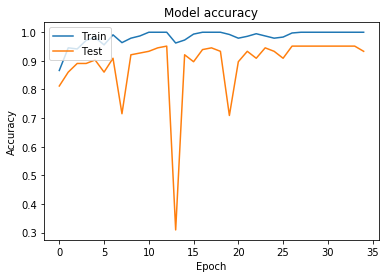

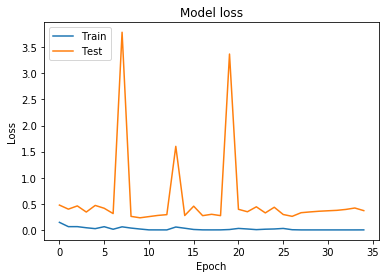

In [78]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Predictions

**Load best weights from checkpointer**

In [79]:
model.load_weights(checkpoint_path + "/weights.h5")

**Score the model with our test set**

In [81]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.3282605703157115
Test accuracy: 0.9397590361445783


**Generate Predictions**

Generates predictions for `display_count` number of sample images from the test set. 

In [86]:
display_count = 6

# Randomly choose display_count samples
indices = np.random.choice(len(X_test), display_count)
X_display = X_test[indices]
Y_display = Y_test[indices]

Pred_display = []
for x in X_display:
    x = np.reshape(x, (1, x.shape[0], x.shape[1], x.shape[2]))
    Pred_display.append(np.argmax(model.predict(x).tolist()[0]))
Y_display = [np.argmax(y) for y in Y_display]

**Display Predictions**

The following code displays a set of predictions (up to 16) and their associated images. If the prediction is wrong, it is highlighted in red.

In [ ]:
rows = math.floor((display_count**.5))
columns = math.ceil(display_count / rows)

# Create the subplots
fig, ax = plt.subplots(rows, columns, figsize=(16,16*(rows/columns)))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.25)

# Format each subplot
for i in range(rows):
    for j in range(columns):
        index = (i * columns) + j
        if index >= len(X_display):
            continue # If the index is out of bounds, skip this plot
        ax[i][j].imshow(X_display[index]) # Display the image
        
        # If the prediction is wrong, display in red. Otherwise, display in black
        color = (0,0,0,1) if Pred_display[index] == Y_display[index] else (0.8,0.1,0.1,1)
        
        # Display the prediction above the image
        title = "No Line" if Pred_display[index] == 1 else "Line"
        ax[i][j].set_title("{}: {}".format(index, title), color=color)

To examine one of the images more closely, use the following cell

In [ ]:
image_id = 1

fig, ax = plt.subplots(1, 1, figsize=(10,10))
fig.tight_layout()
plt.imshow(X_display[image_id])

In [89]:
# Close the keras session, freeing up GPU
keras.backend.clear_session()

*** 
## Hyperparameter Optimization 

**Define optimizers**

In [65]:
def sgd(lr=0.0001):
    return SGD(lr=lr, momentum=0.9)

def rmsprop(lr=0.0001):
    return RMSprop(lr=lr, rho=0.9, epsilon=None, decay=0.0)

def adagrad(lr=0.0001):
    return Adagrad(lr=lr, epsilon=None, decay=0.0)

def adadelta(lr=0.0001):
    return Adadelta(lr=lr, rho=0.95, epsilon=None, decay=0.0)

def adam(lr=0.0001):
    return Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

def adamax(lr=0.0001):
    return Adamax(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

def nadam(lr=0.0001):
    return Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

**Define model generator**

In [93]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(training=0, learning_rate=0.0001, optimizer="Adam"):    
    # Create the ResNet50 base model Dense(1000) layers
    resnet_base = ResNet50(weights="imagenet", input_shape=(input_size[0], input_size[1], 3), include_top=False, pooling="avg")
    
    # Add 2 dense layers and a final prediction layer
    top = Dense(1024, activation="relu")(resnet_base.output) # TEST: kernel_regularizer = regularizers.l2(0.05)
    top = Dense(256, activation="relu")(top)
    predictions = Dense(2, activation="softmax")(top)
    model = Model(inputs=resnet_base.input, outputs=predictions)
    
    training = max(training, 0)
    training = min(training, len(model.layers))
    
    # Disable all layers by default
    for layer in model.layers[:]:
        layer.trainable = False
    
    # Select all layers to train
    for layer in model.layers[-training:]:
        layer.trainable = True
    
    # Collect the trainable status of each layer
    data = []
    for layer in model.layers:
        data.append([str(layer), str(layer.trainable)])

    # Print the trainable status in nice columns
    col_width = max(len(word) for row in data for word in row) + 2 
    for row in data:
        row[0] = row[0].ljust(col_width, ".")
        # Uncomment to print trainable status
        #print("\t".join(word.ljust(col_width, " ") for word in row))
        
    # Compile model
    optimizers = {
        'SGD': sgd(lr=learning_rate), 
        'RMSprop': rmsprop(lr=learning_rate), 
        'Adagrad': adagrad(lr=learning_rate), 
        'Adadelta': adadelta(lr=learning_rate), 
        'Adam': adam(lr=learning_rate), 
        'Adamax': adamax(lr=learning_rate), 
        'Nadam': nadam(lr=learning_rate)
    }
    op = optimizers[optimizer]

    model.compile(optimizer=op, loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

model = KerasClassifier(build_fn=create_model, epochs=100, verbose=2)

**Define the parameter grid**

In [96]:
params = {
    "batch_size": [16, 8, 4, 2],
    "training": [3, 102, 200],
    "learning_rate": [0.001, 0.0001, 0.00001],
    "optimizer": ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    "class_weight": [{0: 3., 1: 1.}],
    "callbacks": [[early_stopping]]
}

**Perform Grid Search**

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=4)
grid_result = grid.fit(samples, labels)